<h1>Automatic Image Caption generator using Deep Learning</h1><br>
<p align="right">21BCE095<br>Jay Pandya</p>

In [1]:
from google.colab import drive
drive.mount('/content/drive') #link to colab

Mounted at /content/drive


<h3>Importing Modules

In [2]:
#pip install "tensorflow<2.11"
#pip install keras
#!pip install tqdm

import os #file handling.
import pickle #storing numpy features(img data).
import numpy as np #for nimpy array and math related functions.
from tqdm.notebook import tqdm # UI for processed data, for loading bar animation.
#VGG16 is a pre-trained convolutional neural network (CNN) used for Image classification tasks.
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input #deep convolutional neural network commonly used for image feature extraction in computer vision tasks
from tensorflow.keras.preprocessing.image import load_img, img_to_array #functions for loading images and converting them to NumPy arrays
from tensorflow.keras.preprocessing.text import Tokenizer #used for text preprocessing, including tokenization.
from tensorflow.keras.preprocessing.sequence import pad_sequences # make all input sequences the same length
from tensorflow.keras.models import Model #used for defining and training neural network models.
from tensorflow.keras.utils import to_categorical, plot_model #for converting labels to categorical format and for plotting Keras models.
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add #imports various layers from Keras, which can be used to build a neural network

In [3]:
BASE_DIR = '/content/drive/MyDrive/ML/images'
WORKING_DIR = '/content/drive/MyDrive/ML'

<h3>Extract Image Features</h3>

In [4]:
#load vgg6 model
model = VGG16() #VGG16 is a pre-trained convolutional neural network (CNN)
#restructure model
"""The VGG16 model, by default, is a complete CNN architecture for image classification. However,
for image captioning, you typically don't need the final classification layer (which is the last layer).
So, you create a new model that takes the same inputs but outputs the activations of the second-to-last layer of the VGG16 model.
 This is done to extract meaningful image features that can be used in the captioning process."""
model = Model(inputs=model.inputs, outputs=model.layers[-2].output) 
#summerize
print(model.summary())
"""By removing the final classification layer, you're essentially repurposing VGG16 as a feature extractor for image captioning."""

553467096/553467096 [==============================] - 25s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

"By removing the final classification layer, you're essentially repurposing VGG16 as a feature extractor for image captioning."

In [5]:
# #extract features from images
# features = {}
# directory = os.path.join(BASE_DIR, 'Images')

# for img_name in tqdm(os.listdir(directory)):#traverse
#     #load the image from file
#     img_path = directory + '/' + img_name
#     image = load_img(img_path, target_size=(224,224))
#     #convert img to numpy array
#     image = img_to_array(image)
#     #reshape data for model
#     image = image.reshape((1(at a time one image), image.shape[0](height), image.shape[1](width), image.shape[2]))#no. of channelsrgb format
#     #preprocess image for vgg
#     image = preprocess_input(image) #mean subtraction and scale data
#     #extract features
#     feature = model.predict(image, verbose=0) #high level features predict key image ID
#     #get image ID
#     image_id = img_name.split('.')[0] #image.jgeg image ni id 0 index store krse
#     #store features
#     features[image_id] = feature

In [6]:
# # store features in pickle
# pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))
!nvidia-smi

Sat Oct 28 19:10:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    27W /  70W |   2533MiB / 15360MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:

# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

<h3>Load Caption

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:

# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')): #line by line iterate
    # split the line by comma(,)
    tokens = line.split(',') #format img_ID , caption
    if len(line) < 2:
        continue
    image_id, caption = tokens[0] #image_id, tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)#list of list

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
len(mapping)

8091

<h3>Preprocess TEXT

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]#5times
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '') # remove any characters that are not alphabetic
            # delete additional spaces
            caption = caption.replace('\s+', ' ') # replace one or more consecutive whitespace characters with a single space
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' #lstm used probabilty of words find
            captions[i] = caption

In [12]:
# before preprocess of text
#mapping['1000268201_693b08cb0e']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
#mapping['1000268201_693b08cb0e']

In [15]:
all_captions = [] #to tokenize
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
#len(all_captions)

In [17]:
#all_captions[:10]

In [18]:
# tokenize the text, process of splitting text into individual words or tokens.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
#vocab_size

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

<h2>Train test split

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90) training
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list() #image features, input sequences, and output sequences.
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] #next word predict to 1 bki 0

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0 

<h3>Create Model

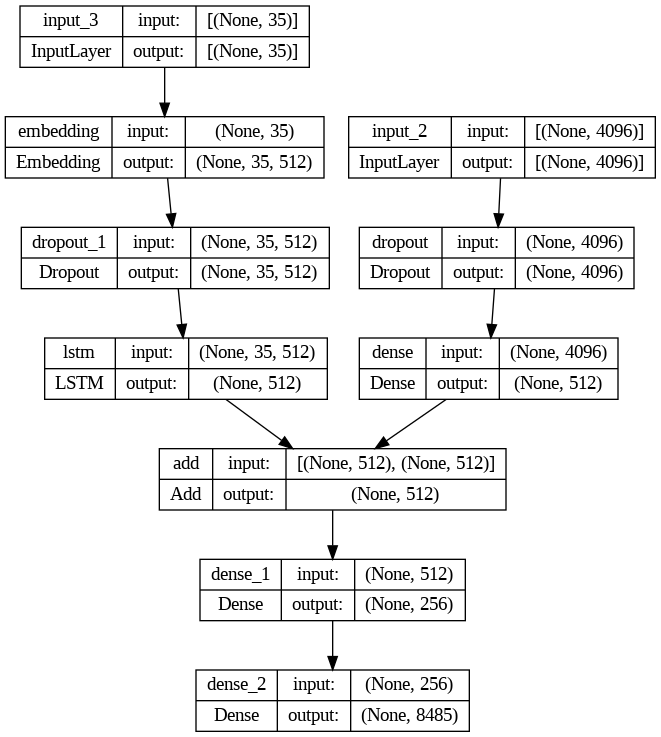

In [24]:
# model Creation
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 512, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(512)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

<h2>Train Model

In [25]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [26]:
# # train the model
# epo = 40
# batch_size = 32
# steps = len(train) // batch_size
# # create data generator
# generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
# # fit for one epoch
# model.fit(generator, epochs=epo, steps_per_epoch=steps, verbose=1 )

In [27]:
# # save the model
# model.save(WORKING_DIR+'/512(5)_model.h5')

In [28]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model(WORKING_DIR+'/best_model.h5')

<h3>Generate caption

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

<h2>Performance Anaysis

In [31]:
# from nltk.translate.bleu_score import corpus_bleu
# # validate with test data
# actual, predicted = list(), list()

# for key in tqdm(test):
#     # get actual caption
#     captions = mapping[key]
#     # predict the caption for image
#     y_pred = predict_caption(model, features[key], tokenizer, max_length)
#     # split into words
#     actual_captions = [caption.split() for caption in captions]
#     y_pred = y_pred.split()
#     # append to the list
#     actual.append(actual_captions)
#     predicted.append(y_pred)

# # calcuate BLEU score
# print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

<h3>Visualize the Result

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq brown dog runs for white and black dog on the grass endseq
startseq white dog and brown dog play in the grass endseq
startseq the dogs are in the field playing endseq
startseq two dogs playing on grass endseq
startseq two dogs play together endseq
--------------------Predicted--------------------
startseq brown dog with brown spots is running in the grass endseq


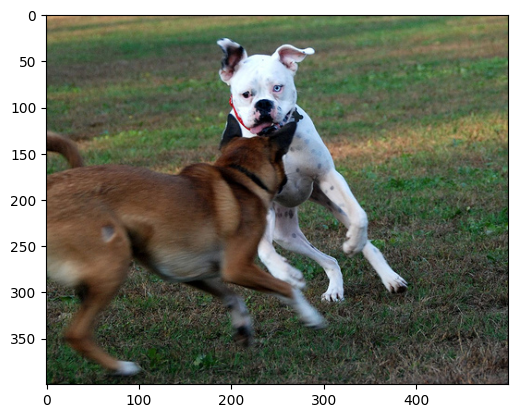

In [33]:
generate_caption("1778020185_1d44c04dae.jpg")

---------------------Actual---------------------
startseq fluffy white dog runs through the woods with his ears flapping in the breeze endseq
startseq small white dog is running across grassy field endseq
startseq "a white dog runs in the grass endseq
startseq white dog wearing red harness runs though the woods endseq
startseq the little white dog wearing the red collar is running in the grass endseq
--------------------Predicted--------------------
startseq two white dogs running in field endseq


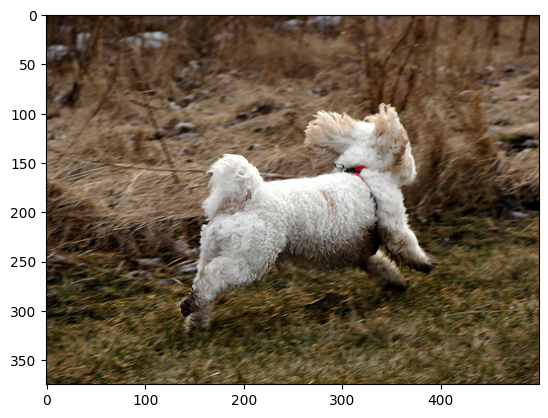

In [42]:
generate_caption("416106657_cab2a107a5.jpg")

<h1>Test with real images

In [35]:
def crt_lk(l):
    l=list(l)

In [36]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'startseq sveral young man in black and white shorts and white shorts is running on the sand endseq'

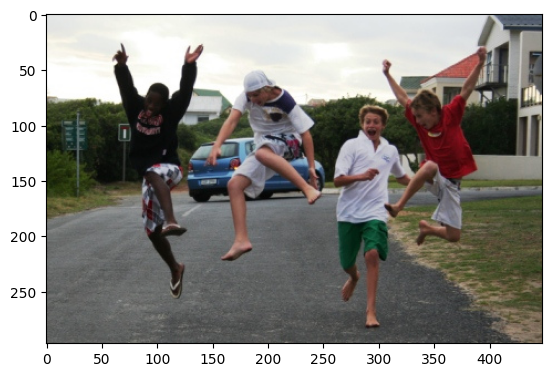

In [44]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = "/content/drive/MyDrive/ML/images/Images/395461421_c586b136de.jpg"
image = Image.open(image_path)
plt.imshow(image)
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)